In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import required Libraries

In [107]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

In [108]:
import warnings
warnings.filterwarnings('ignore')

In [164]:
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

Import modules

In [109]:
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import PreProcess
from overview import Overview 
overview = Overview()
preProcess = PreProcess()
from plot import Plot
pl = Plot()
from logger import Logger

In [110]:
# Initialize logger
logger = Logger("userEngagement.log").get_app_logger()
logger.info("Initialized user_experience logger")

#### Import the Data

In [111]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/outlier_data.csv')

In [112]:
df = df_org.copy()

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   bearer_id                       150001 non-null  float64
 1   start                           150001 non-null  object 
 2   start_ms                        150001 non-null  float64
 3   end                             150001 non-null  object 
 4   end_ms                          150001 non-null  float64
 5   dur._(ms)                       150001 non-null  float64
 6   imsi                            150001 non-null  float64
 7   msisdn/number                   150001 non-null  float64
 8   imei                            150001 non-null  float64
 9   last_location_name              150001 non-null  object 
 10  avg_rtt_dl_(ms)                 150001 non-null  float64
 11  avg_rtt_ul_(ms)                 150001 non-null  float64
 12  avg_bearer_tp_dl

All missing values have been handled

<AxesSubplot:>

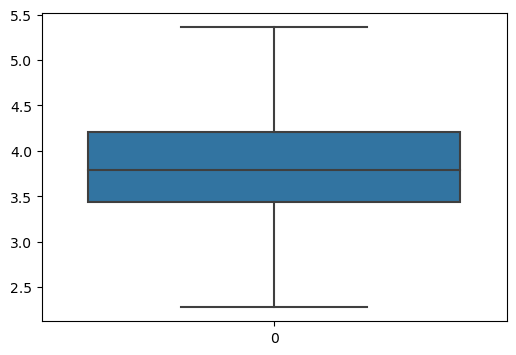

In [114]:
plt.figure(figsize=(6, 4))
sns.boxplot(df['avg_rtt_dl_(ms)'], orient='vert')

>> Aggregate, per customer
        - Average TCP retransmission
        - Average RTT
        - Handset type
        - Average throughput

In [115]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'activity_duration_dl_(ms)', 'activity_duration_ul_(ms)', 'dur._(ms).1',
       'handset_manufacturer', 'handset_type', 'nb_of_sec_with_vol_dl_<_6250b',
       'nb_of_sec_with_vol_ul_<_1250b', 'social_media_dl_(bytes)',
       'social_media_ul_(bytes)', 'google_dl_(bytes)', 'google_ul_(bytes)',
       'email_dl_(bytes)', 'email_ul_(bytes)', 'youtube_dl_(bytes)',
       'youtube_ul_(bytes)', 'netflix_dl_(bytes)', 'netflix_ul_(bytes)',


Get the total transimissions for each customer

In [116]:
user_experience = df[[
    "msisdn/number",
    "avg_rtt_dl_(ms)",
    "avg_rtt_ul_(ms)",
    "avg_bearer_tp_dl_(kbps)",
    "avg_bearer_tp_ul_(kbps)",
    "tcp_dl_retrans._vol_(bytes)",
    "tcp_ul_retrans._vol_(bytes)",
    "handset_type"]]

user_experience['avg_rtt_total'] = user_experience['avg_rtt_dl_(ms)'] + user_experience['avg_rtt_ul_(ms)']
user_experience['avg_bearer_tp_total'] = user_experience['avg_bearer_tp_dl_(kbps)'] + user_experience['avg_bearer_tp_ul_(kbps)']
user_experience['avg_tcp_retrans_total'] = user_experience['tcp_dl_retrans._vol_(bytes)'] + user_experience['tcp_ul_retrans._vol_(bytes)']

In [117]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,12.888642,9.713779,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,22.60242
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,12.888642,9.713779,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,22.60242
2,3.376063e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Galaxy A8 (2018),5.783825,3.988984,22.60242
3,3.375034e+10,4.174387,1.609438,3.784190,3.784190,12.888642,9.713779,undefined,5.783825,7.568379,22.60242
4,3.369980e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Sm-G390F,5.783825,3.988984,22.60242


In [118]:
user_experience_agg = user_experience.groupby('msisdn/number').agg({
    'avg_rtt_total': 'sum',
    'avg_bearer_tp_total': 'sum',
    'avg_tcp_retrans_total': 'sum',
    'handset_type': [lambda x: x.mode()[0]]})

user_experience_df = pd.DataFrame()

user_experience_df["avg_rtt_total"] = user_experience_agg["avg_rtt_total"]['sum']
user_experience_df["avg_tp_total"] = user_experience_agg["avg_bearer_tp_total"]['sum']
user_experience_df["total_avg_tcp_total"] = user_experience_agg["avg_tcp_retrans_total"]['sum']
user_experience_df["handset_type"] = user_experience_agg["handset_type"]['<lambda>']
user_experience_df.head()

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,1.714085,7.274480,22.960679,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,16.743874,Apple iPhone 7 (A1778)
3.360100e+10,5.762051,7.763021,27.390146,undefined
3.360101e+10,6.942157,9.102310,15.263215,Apple iPhone 5S (A1457)
3.360101e+10,7.281434,27.135851,49.791876,Apple iPhone Se (A1723)


>> ##### Compute & list 10 of the top, bottom and most frequent:

In [119]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,12.888642,9.713779,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,22.60242
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,12.888642,9.713779,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,22.60242
2,3.376063e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Galaxy A8 (2018),5.783825,3.988984,22.60242
3,3.375034e+10,4.174387,1.609438,3.784190,3.784190,12.888642,9.713779,undefined,5.783825,7.568379,22.60242
4,3.369980e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Sm-G390F,5.783825,3.988984,22.60242


In [120]:
top_10_tcp = user_experience.nlargest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
bottom_10_tcp = user_experience.nsmallest(10, 'avg_bearer_tp_total')['avg_bearer_tp_total']
most_frequent_tcp = user_experience.value_counts('avg_bearer_tp_total').nlargest(10)


[]

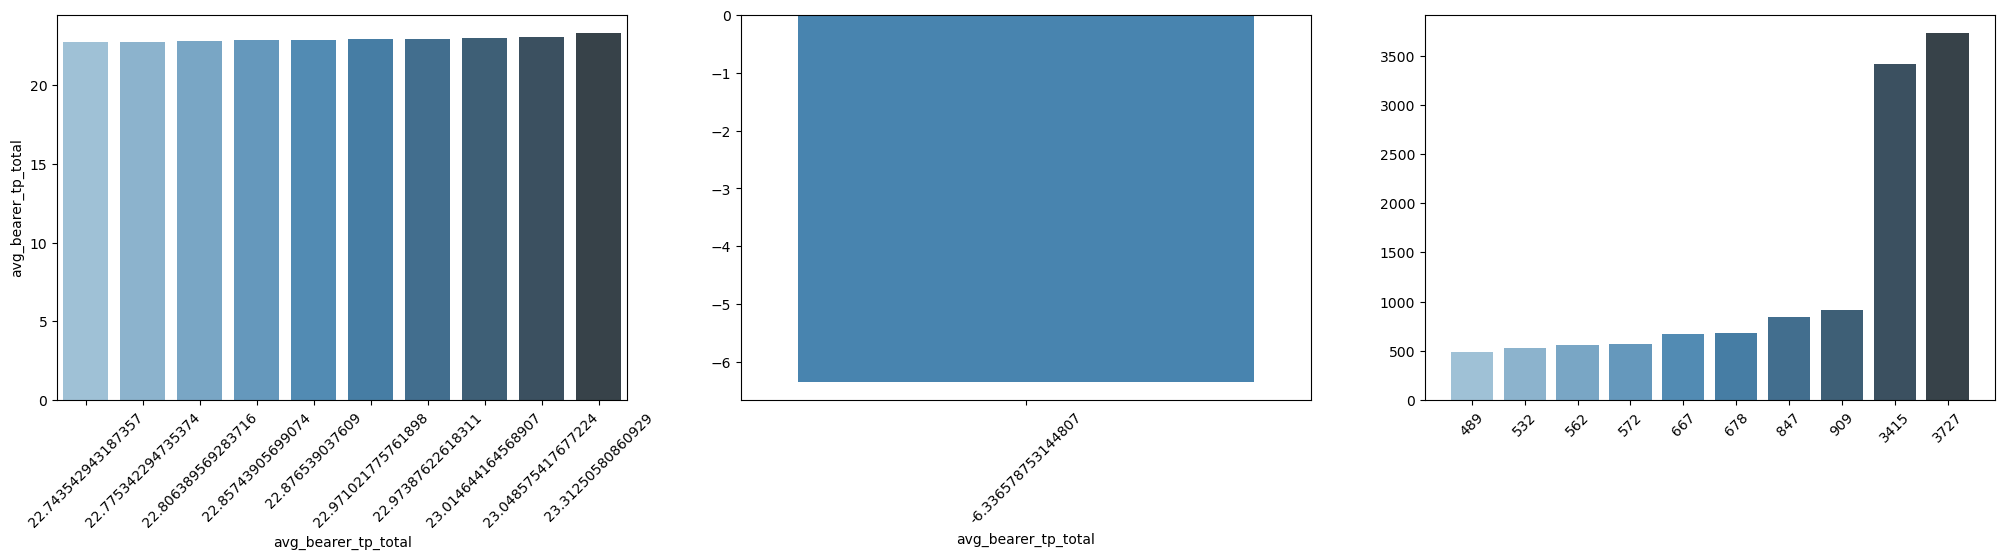

In [121]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_tcp, x=top_10_tcp.index, orient='v', y=top_10_tcp, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_tcp, x=bottom_10_tcp.index,orient='v', y=bottom_10_tcp.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_tcp, x=most_frequent_tcp.index,orient='v', y=most_frequent_tcp.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


RTT VALUES 

[]

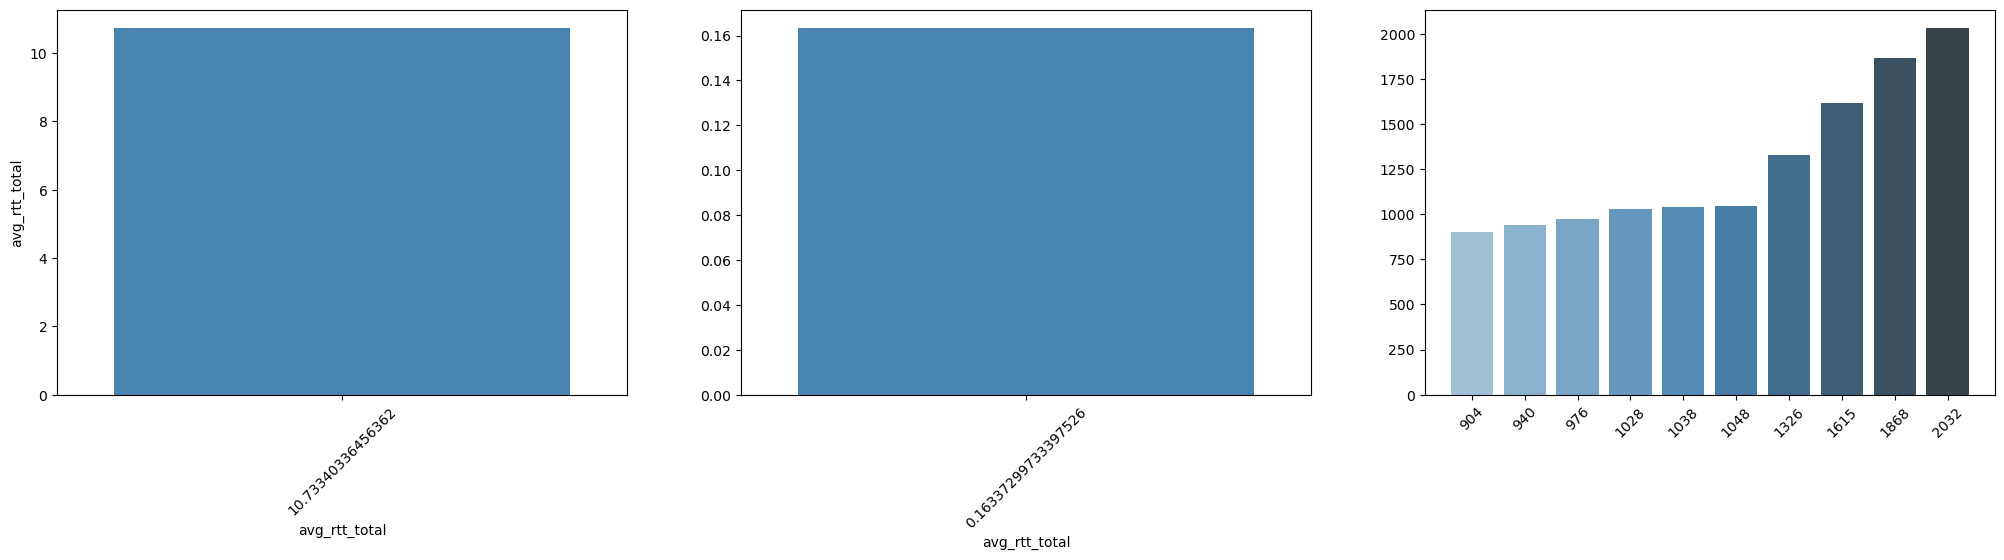

In [122]:
top_10_rtt = user_experience.nlargest(10, 'avg_rtt_total')['avg_rtt_total']
bottom_10_rtt = user_experience.nsmallest(10, 'avg_rtt_total')['avg_rtt_total']
most_frequent_rtt = user_experience.value_counts('avg_rtt_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_rtt, x=top_10_rtt.index, orient='v', y=top_10_rtt, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_rtt, x=bottom_10_rtt.index,orient='v', y=bottom_10_rtt.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_rtt, x=most_frequent_rtt.index,orient='v', y=most_frequent_rtt.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


Throughput values

[]

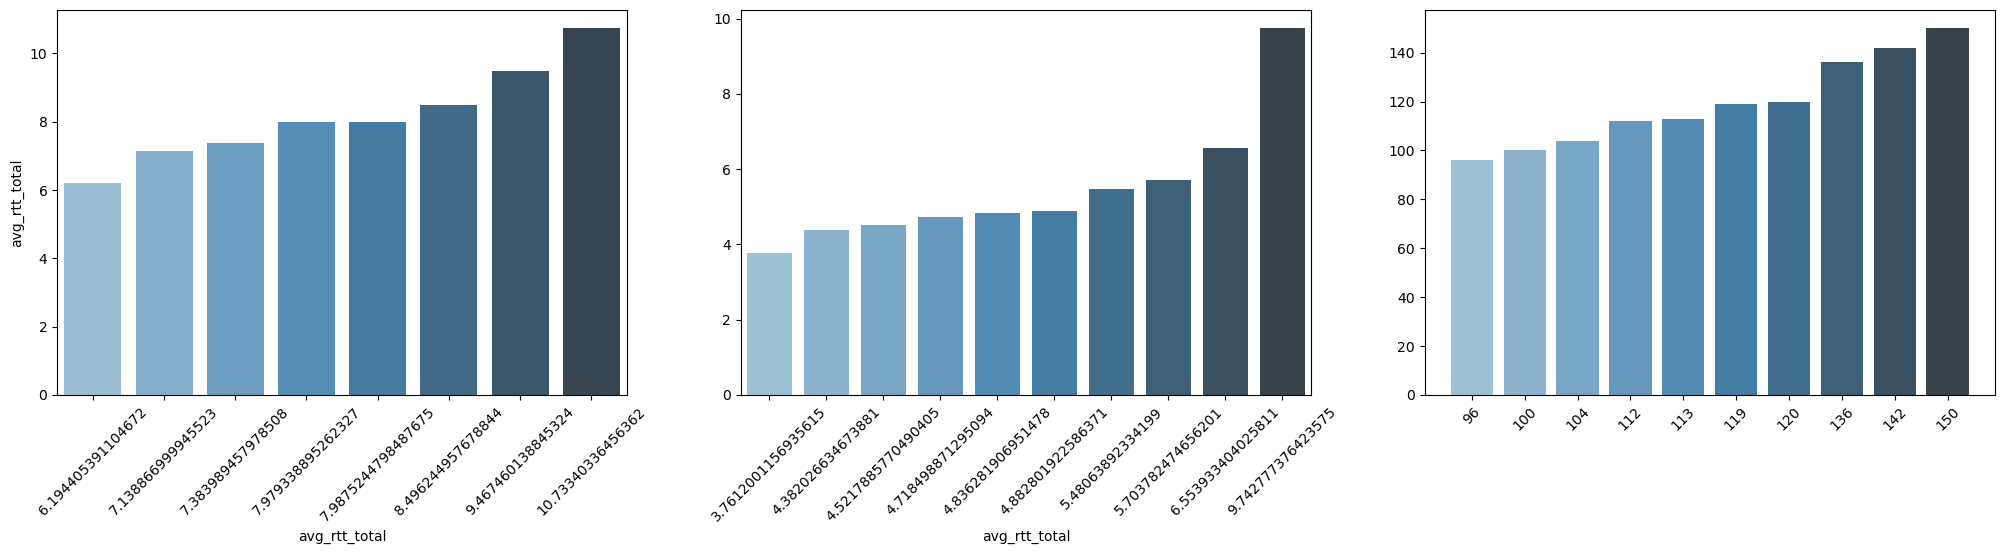

In [123]:
top_10_retrans = user_experience.nlargest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
bottom_10_retrans = user_experience.nsmallest(10, 'avg_tcp_retrans_total')['avg_rtt_total']
most_frequent_retrans = user_experience.value_counts('avg_tcp_retrans_total').nlargest(10)


f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=top_10_retrans, x=top_10_retrans.index, orient='v', y=top_10_retrans, ax=axes[0], palette='Blues_d')
ax2 = sns.barplot(data=bottom_10_retrans, x=bottom_10_retrans.index,orient='v', y=bottom_10_retrans.values, ax=axes[1], palette='Blues_d')
ax3 = sns.barplot(data=most_frequent_retrans, x=most_frequent_retrans.index,orient='v', y=most_frequent_retrans.values, ax=axes[2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


>> #### The distribution of the average throughput  per handset type and provide interpretation for your findings.


Distribution of the average throughput per handset

In [124]:
user_experience.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_dl_retrans._vol_(bytes),tcp_ul_retrans._vol_(bytes),handset_type,avg_rtt_total,avg_bearer_tp_total,avg_tcp_retrans_total
0,3.366496e+10,3.737670,1.609438,3.135494,3.784190,12.888642,9.713779,Samsung Galaxy A5 Sm-A520F,5.347108,6.919684,22.60242
1,3.368185e+10,4.174387,1.609438,2.772589,3.258097,12.888642,9.713779,Samsung Galaxy J5 (Sm-J530),5.783825,6.030685,22.60242
2,3.376063e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Galaxy A8 (2018),5.783825,3.988984,22.60242
3,3.375034e+10,4.174387,1.609438,3.784190,3.784190,12.888642,9.713779,undefined,5.783825,7.568379,22.60242
4,3.369980e+10,4.174387,1.609438,1.791759,2.197225,12.888642,9.713779,Samsung Sm-G390F,5.783825,3.988984,22.60242


In [125]:
handset_type_df = user_experience.groupby('handset_type').agg(
    {'avg_bearer_tp_total': 'mean', 'avg_tcp_retrans_total': 'mean'})
handset_type_df.head()

,avg_bearer_tp_total,avg_tcp_retrans_total
handset_type,,
A-Link Telecom I. Cubot A5,15.838115,23.522065
A-Link Telecom I. Cubot Note Plus,13.931197,22.845643
A-Link Telecom I. Cubot Note S,15.094590,28.653651
A-Link Telecom I. Cubot Nova,17.237061,19.012167
A-Link Telecom I. Cubot Power,16.978497,14.450689


Top throughput

In [137]:
top_tp = handset_type_df.nlargest(10, 'avg_bearer_tp_total').reset_index()
top_tp

,handset_type,avg_bearer_tp_total,avg_tcp_retrans_total
0,Zyxel Communicat. Sbg3600,20.908578,32.736755
1,Xiaomi Communica. M1803E1A,20.867537,20.462464
2,Huawei B715S-23C,20.854396,28.546554
3,Ovvi-Cellphone T. Echo,20.731326,25.110843
4,Oppo Cph1701,20.703960,23.391475
5,Lg Lg-H818P,20.681494,27.090212
6,Zyxel Communicat. Lte7460,20.598662,32.777015
7,Samsung Galaxy S9+,19.832915,14.839766
8,Oppo Cph1723,19.682278,19.323550
9,Archos Sa 55 Diamond Selfie ( Lite),19.619881,22.926009


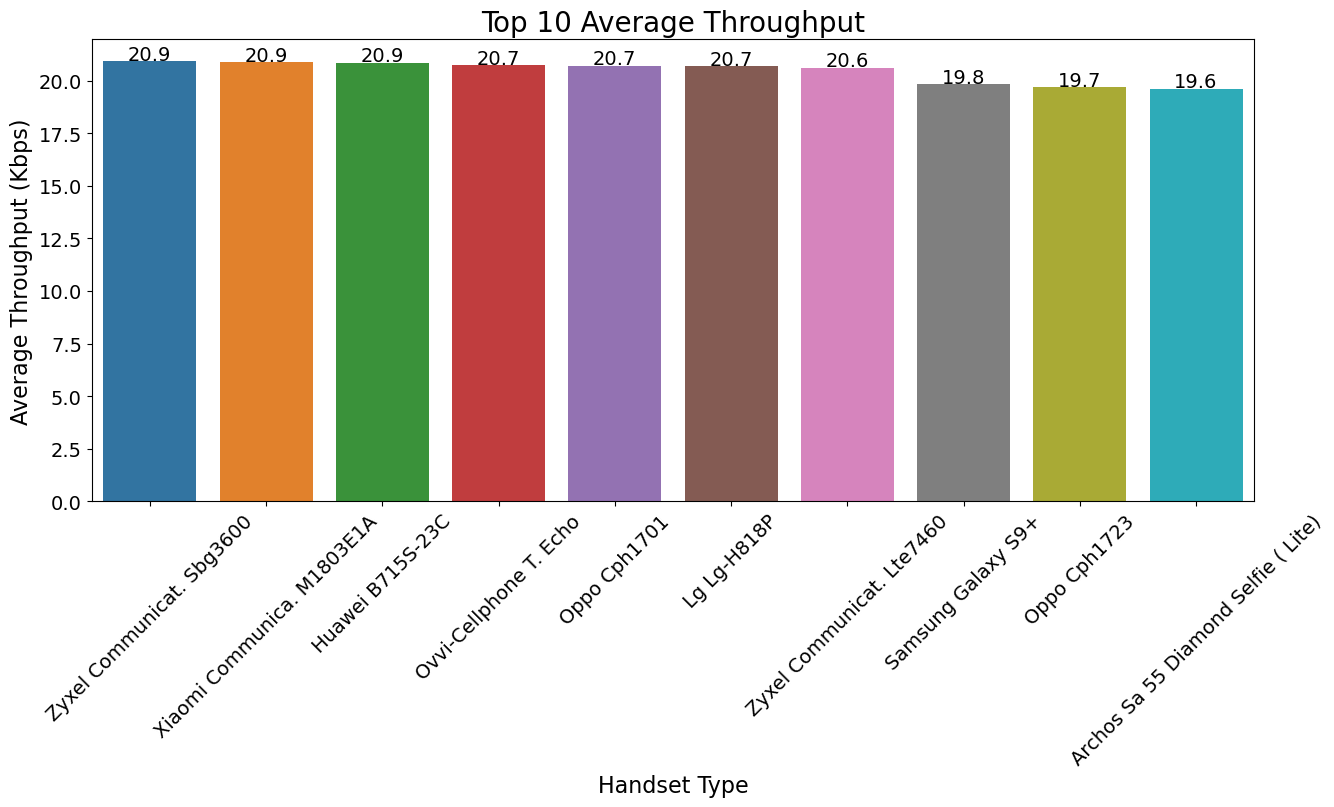

In [141]:
pl.barplot(top_tp ,'handset_type', 'avg_bearer_tp_total', "Top 10 Average Throughput", "Handset Type", "Average Throughput (Kbps)")

The highest amount of throughput is of the handset type: Zyxel Communicat. Sbg3600, then comes Xiaomi Communica. M1803E1A, followed by the Huawei B715S-23C.

>> The average TCP retransmission view per handset type and provide interpretation for your findings.

Top TCP retransmission

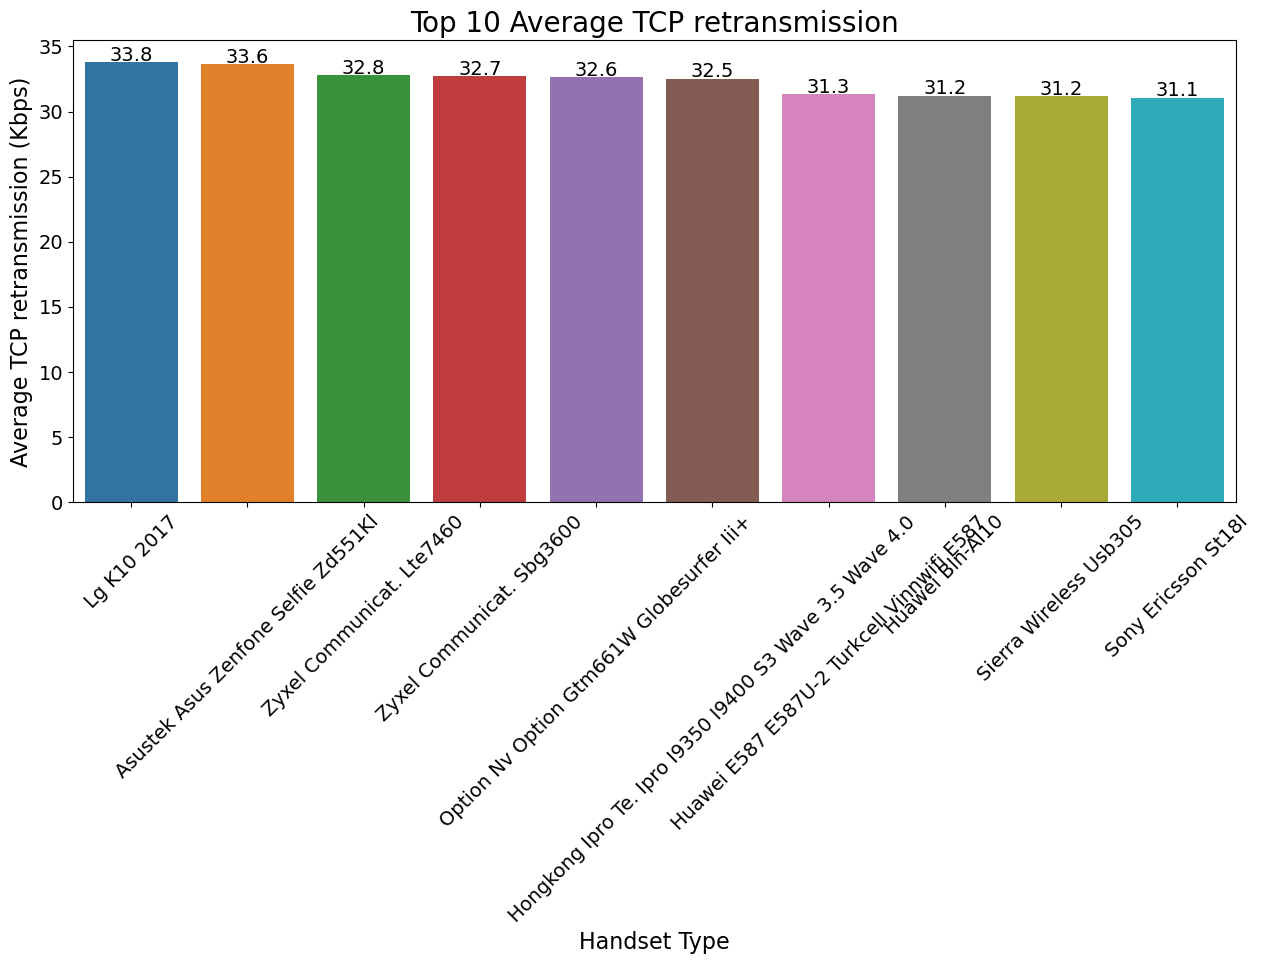

In [144]:
top_tcp = handset_type_df.nlargest(10, 'avg_tcp_retrans_total').reset_index()
pl.barplot(top_tcp ,'handset_type', 'avg_tcp_retrans_total', "Top 10 Average TCP retransmission", "Handset Type", "Average TCP retransmission (Kbps)")

The  Zyxel Communicat. Sbg3600 phones seems to have high throughput as well as highes tcp transmissions

>> #### Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)

In [145]:
user_experience_df.head(2)

,avg_rtt_total,avg_tp_total,total_avg_tcp_total,handset_type
msisdn/number,,,,
3.360100e+10,1.714085,7.274480,22.960679,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,3.401197,7.803027,16.743874,Apple iPhone 7 (A1778)


In [146]:
# Drop the handset_type column
user_experience = user_experience_df.drop(['handset_type'], axis=1)

In [147]:
#  Replace inf values with null then fill with the column mean
user_experience.replace([np.inf, -np.inf], np.nan, inplace=True)

In [148]:
user_experience.isnull().sum()

avg_rtt_total          0
avg_tp_total           0
total_avg_tcp_total    0
dtype: int64

In [149]:
# replace the missing values with the mean of the column
user_experience = user_experience.fillna(user_experience.mean())

In [150]:
def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data 
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [151]:
normalized_user_experience = normalizer(user_experience, ['avg_rtt_total',	'avg_tp_total',	'total_avg_tcp_total'] )

In [152]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_user_experience)
centroids = kmeans.cluster_centers_

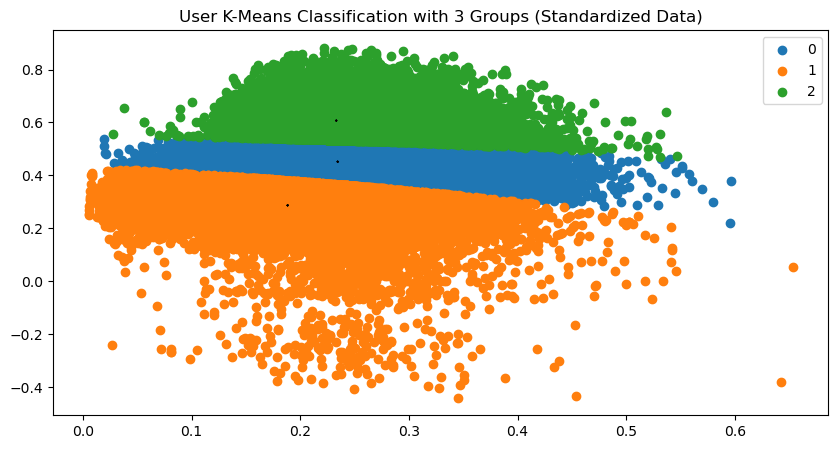

In [153]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_user_experience[label == i].iloc[:,0] , normalized_user_experience[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [154]:
logger.info(f'# Centroids of the clustering:\n{centroids}')
logger.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
logger.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

 Customers that grouped into cluster 0 have higher transmission rate(throughput) and a lower re-transmission meaning that it successfully reaches its destination whcih means that they have a good connection. On the other hand customers grouped into cluster 3 have higher retransmission which means that they have a poor connection. Customers in group 2 has good throuput rate compared to customers in cluster 3.

Add cluster group to the dataframe

In [155]:
u_exp = user_experience.copy()
u_exp.insert(0, 'cluster', kmeans.labels_)
u_exp.head(5)

,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
msisdn/number,,,,
3.360100e+10,1,1.714085,7.274480,22.960679
3.360100e+10,0,3.401197,7.803027,16.743874
3.360100e+10,1,5.762051,7.763021,27.390146
3.360101e+10,0,6.942157,9.102310,15.263215
3.360101e+10,0,7.281434,27.135851,49.791876


Clusters overview

In [156]:
cluster1 = u_exp[u_exp["cluster"]==0]
cluster2 = u_exp[u_exp["cluster"] == 1]
cluster3 = u_exp[u_exp["cluster"] == 2]

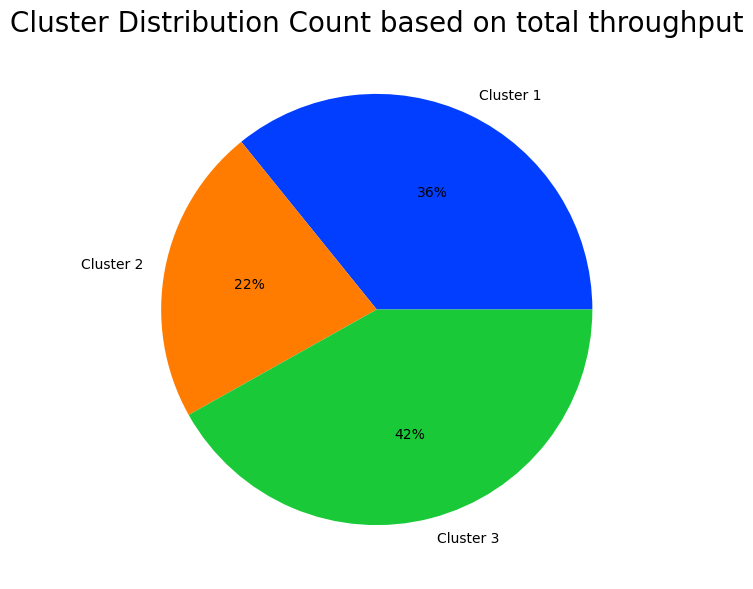

In [157]:
data = [cluster1.avg_tp_total.sum(), cluster2.avg_tp_total.sum(), cluster3.avg_tp_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count based on total throughput")

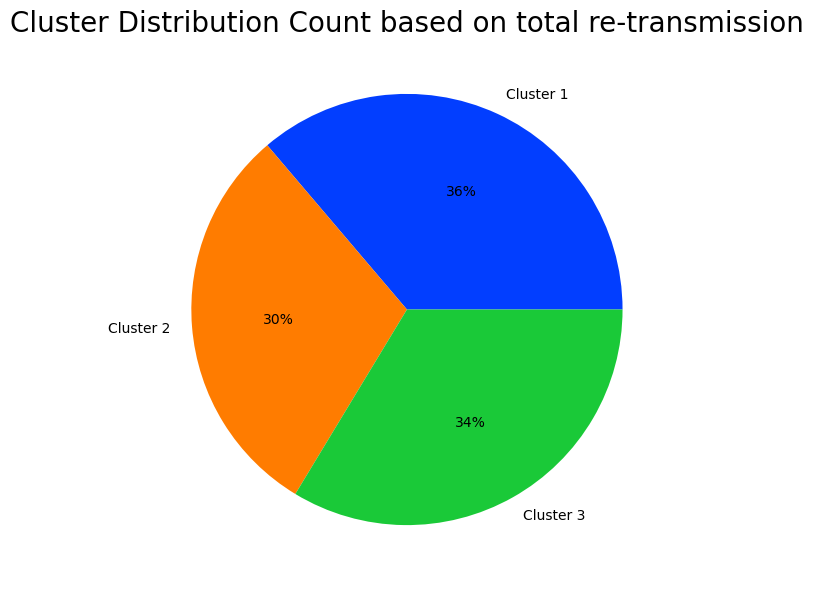

In [158]:
data = [cluster1.avg_rtt_total.sum(), cluster2.avg_rtt_total.sum(), cluster3.avg_rtt_total.sum()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count based on total re-transmission")

In [159]:
u_exp.shape

(106856, 4)

In [160]:
u_exp.head()

,cluster,avg_rtt_total,avg_tp_total,total_avg_tcp_total
msisdn/number,,,,
3.360100e+10,1,1.714085,7.274480,22.960679
3.360100e+10,0,3.401197,7.803027,16.743874
3.360100e+10,1,5.762051,7.763021,27.390146
3.360101e+10,0,6.942157,9.102310,15.263215
3.360101e+10,0,7.281434,27.135851,49.791876


>> Save the data

In [161]:
with open("../models/user_exp.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [162]:
u_exp.to_csv('../data/user_exp.csv')

In [163]:
user_experience.to_csv('../data/user_experience.csv')